In [1]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
from scipy.signal import detrend
import pandas as pd
import pickle
from scipy import fftpack
import string

proj_dir = '/home/ubuntu/bigStick/antarctic_melting'
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
pro_dir = os.path.join(data_dir,'processed')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)
tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

%load_ext autoreload
%autoreload 2

from pySSA.mySSA import mySSA
from log_progress import log_progress
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

In [2]:
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

sel1 = {'xi_rho':slice(714,1243),'eta_rho':slice(1408,1875)} #FRIS
sel2 = {'xi_rho':slice(1185,1726),'eta_rho':slice(652,1146)} #Ross
sel3 = {'xi_rho':slice(380,648),'eta_rho':slice(1114,1780)} #BSeas
sel4 = {'xi_rho':slice(655,924),'eta_rho':slice(720,1244)} #ASeas
sel5 = {'xi_rho':slice(2568,2665),'eta_rho':slice(637,867)} # Totten
sel6 = {'xi_rho':slice(2322,2652),'eta_rho':slice(1650,1781)} # Amery
sel7 = {'xi_rho':slice(1409,1595),'eta_rho':slice(2338,2496)} # Fimbul
sel8 = {'xi_rho':slice(295,534),'eta_rho':slice(1830,2030)} # LarsenC
sel9 = {'xi_rho':slice(390,650),'eta_rho':slice(1500,1775)} # GeorgeV
sel10 = {'xi_rho':slice(550,775),'eta_rho':slice(1000,1250)} # PI
sel11 = {'xi_rho':slice(2550,2750),'eta_rho':slice(650,860)} # Totten
sel12 = {'xi_rho':slice(2330,2640),'eta_rho':slice(1550,1850)} # Amery
sel13 = {'xi_rho':slice(425*5,455*5),'eta_rho':slice(45*5,75*5)} # Mertz
sel14 = {'xi_rho':slice(545*5,595*5),'eta_rho':slice(200*5,250*5)} # Shackleton
sel15 = {'xi_rho':slice(550*2,700*2),'eta_rho':slice(1000*2,1175*2)} #Riiser-Larsen
sel16 = {'xi_rho':slice(460*2,620*2),'eta_rho':slice(320*2,400*2)} #Nickerson
sel17 = {'xi_rho':slice(675*2,1595),'eta_rho':slice(2338,2496)} # Fimbul & Jelbart

sels = {'FRIS':sel1,'ASeas':sel4,'Ross':sel2,'GeorgeV':sel9,'PI':sel10,'Totten':sel11,
        'Amery':sel12,'Fimbul':sel7,'LarsenC':sel8,'Mertz':sel13,'Shackleton':sel14,'BSeas':sel3,'Riiser-Larsen':sel15,
       'Nickerson':sel16,'Jelbart':sel17}

for key,sel in sels.items():
    for k,i in sel.items():
        sels[key][k] = slice(i.start//2,i.stop//2)

<IPython.core.display.Javascript object>


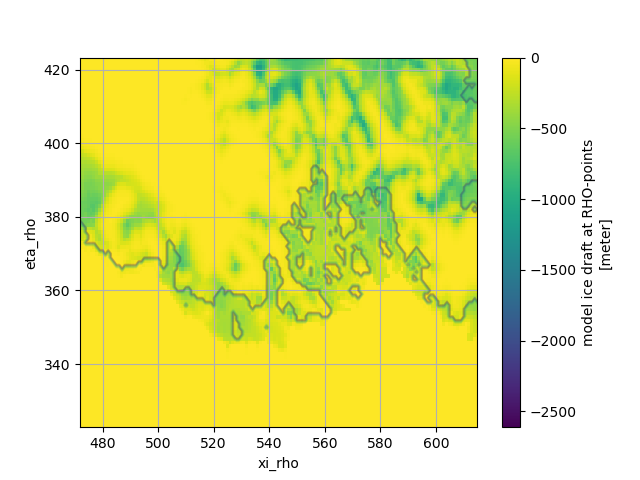

In [77]:
%matplotlib notebook
fig,ax = plt.subplots()
grd.zice.plot(ax=ax)
grd.mask_rho.plot.contour(ax=ax,alpha=0.2)
ax.grid()
plt.show()

In [3]:
def plot_region(tides,no_tides,sel,key):
    
    for k,i in sel.items():
        sel[k] = slice(i.start//2,i.stop//2)
    
    print('subsetting ...')
    t = tides.isel(sel)
    nt = no_tides.isel(sel)
    mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(sel)
    chunks = {'xi_rho':50,'eta_rho':50}
    t = t.chunk(chunks)
    nt = nt.chunk(chunks)
    
    print('processing dyn component ...')
    dyn = ((t.ustar-nt.ustar)*nt.Tstar).where(mask).mean('ocean_time').load()
    print('processing therm component ...')
    therm = ((t.Tstar-nt.Tstar)*nt.ustar).where(mask).mean('ocean_time').load()
    print('processing cov component ...')
    cov = ((t.ustar-nt.ustar)*(t.Tstar-nt.Tstar)).where(mask).mean('ocean_time').load()
    print('processing dMstar ...')
    dMstar = ((t.ustar*t.Tstar).where(mask).mean('ocean_time')-
              (nt.ustar*nt.Tstar).where(mask).mean('ocean_time')).load()
    
    outpath = os.path.join(pro_dir,'dynThermDecomp_'+key+'.nc')
    print('saving results to '+outpath+' ...')
    decomp = xr.Dataset({'dyn':dyn,'therm':therm,'cov':cov,'dMstar':dMstar})
    decomp.to_netcdf(outpath)
    
    print('plotting ... ')
    plot_decomp(decomp)
    
    
def plot_m(ax,da,text,vmin=None,vmax=None):
    total = da.mean()*10000
    da = da *10000
    cmap = ocm.balance
    cmap.set_bad(color='white')
    if vmin == None:
        da.plot(ax=ax,vmin=-da.std()*2,vmax=da.std()*2,cmap=cmap,
                cbar_kwargs={'label': 'u*T* in $10^{-4}$ m/s*degC'})
    else:
        da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,
                cbar_kwargs={'label': 'u*T* in $10^{-4}$ m/s*degC'})

    #ax = make_text(ax,f'mean: {total.values:.2f}'+' $10^{-5}$ m/s*degC)')
    #ax.set_title(f'{text} (mean: {total.values:.2f})')
    ax.set_title(text)
    return ax

def plot_m(ax,da,grd,text,vmin=None,vmax=None):
    total = da.mean()*10000
    da = da *10000
    mask = (grd.mask_rho==1) & (grd.zice<0)
    da = da.where(mask)
    cmap = ocm.balance
    cmap.set_bad(color='white')
    if vmin == None:
        plot = ax.pcolormesh(da.values,vmin=-da.std()*2,vmax=da.std()*2,cmap=cmap)
    else:
        plot = ax.pcolormesh(da.values,vmin=vmin,vmax=vmax,cmap=cmap)
    
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))

    #ax = make_text(ax,f'mean: {total.values:.2f}'+' $10^{-5}$ m/s*degC)')
    #ax.set_title(f'{text} (mean: {total.values:.2f})')
    ax.set_title(text,size=14)
    return plot,ax

def make_text(ax,text):
    ax.text(0.1, 0.1, text, horizontalalignment='center',verticalalignment='center',
                   transform=ax.transAxes)
    return ax


def plot_decomp(reg,ref,vmin=None,vmax=None,figsize=(6,4),save=False,title=False):
    base_path = os.path.join(raw_dir,'scratch','decomp','regions') 
    file = os.path.join(base_path,'decomp'+ref+reg+'.nc')
    print('processing file: '+file)
    decomp = xr.open_dataset(file)
    #decomp.attrs['region']=reg
    grds = grd.isel(sels[reg])
    if vmax==None:
        vmax = decomp.dMstar.std()*40000
        vmin=-vmax
    
    fig,axes = plt.subplots(ncols=2,nrows=2,figsize=figsize)
    ax1,ax2,ax3,ax4 = axes.flatten()

    #ax1 = plot_m(ax1,decomp.dMstar,'$\overline{u^*_T T^*_T}-\overline{u^*_{NT} T^*_{NT}}$',vmin,vmax)
    #ax2 = plot_m(ax2,decomp.therm,'$\overline{u^*_{NT} (T^*_T-T^*_{NT})}$',vmin,vmax)
    #ax3 = plot_m(ax3,decomp.dyn,'$\overline{(u^*_T-u^*_{NT}) T^*_T}$',vmin,vmax)
    #ax4 = plot_m(ax4,decomp.cov,'$\overline{(u^*_T-u^*_{NT}) (T^*_T-T^*_{NT})}$',vmin,vmax)
    if ref == 'RefTide':
        decomp['dyn'] = -decomp.dyn
        decomp['therm'] =-decomp.therm
        decomp['dMstar'] =-decomp.dMstar
    
    
    plot,ax1 = plot_m(ax1,decomp.dMstar,grds,'Total',vmin,vmax)
    plot,ax2 = plot_m(ax2,decomp.dyn,grds,'Dynamical',vmin,vmax)
    plot,ax3 = plot_m(ax3,decomp.therm,grds,'Thermodynamical',vmin,vmax)
    if ref != 'RefCentral':
        plot,ax4 = plot_m(ax4,decomp.cov,grds,'Covariational',vmin,vmax)

    n=0
    for n,ax in enumerate(axes.flatten()):
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_facecolor('gray')
        #ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)
    
    cax = fig.add_axes([1.0, 0.05, 0.05, 0.9])
    cbar = fig.colorbar(plot,cax=cax,extend='both')
    cbar.set_label(label='u*T* in $10^{-4}$ m/s $^{\circ}$C',weight='bold',size=12)
    #cbar = fig.colorbar(plot, ax=axes.ravel().tolist(), shrink=0.95)
    #fig.suptitle(reg+' '+ref,size=16) 
    if title:
        fig.suptitle(title,size=16)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01,hspace=0.1)
    if save:
        plt.savefig(os.path.join(fig_dir,'dynThermDecomp'+ref+reg+'.png'),format='png',bbox_inches = "tight",dpi=300)
    plt.show()

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


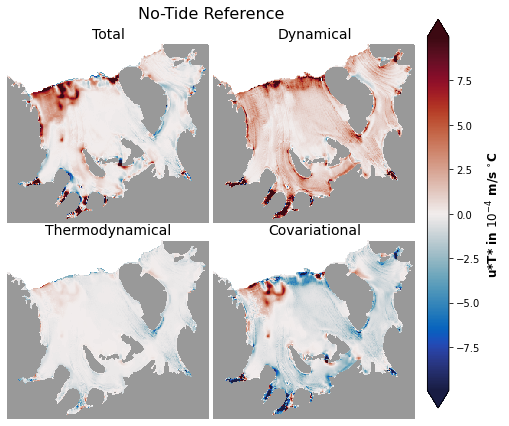

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


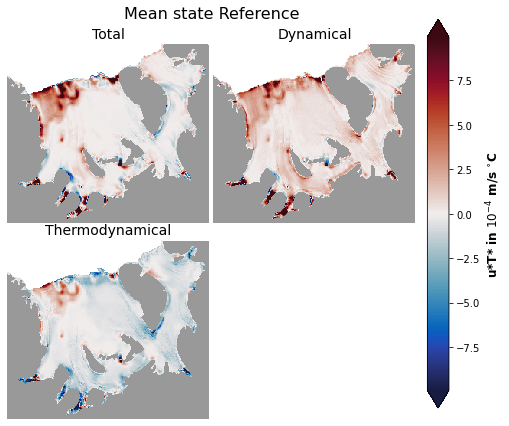

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


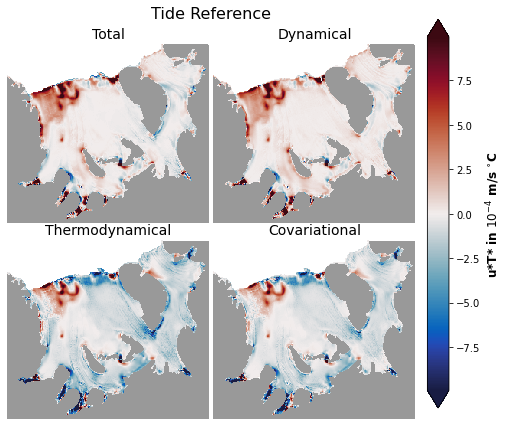

In [18]:
plot_decomp('FRIS','RefNoTide',figsize=(6,6),save=True,title='No-Tide Reference')
plot_decomp('FRIS','RefCentral',figsize=(6,6),save=True,title='Mean state Reference')
plot_decomp('FRIS','RefTide',figsize=(6,6),save=True,title='Tide Reference')

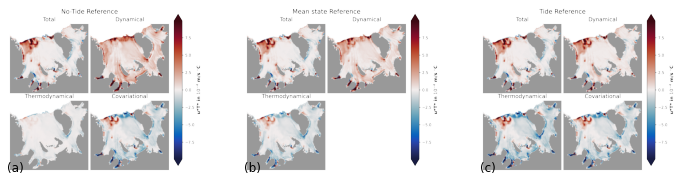

In [19]:
import matplotlib.image as mpimg
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(12,6))
n=0
for i,ref in enumerate(['RefNoTide','RefCentral','RefTide']):
     axes[i].imshow(plt.imread(os.path.join(fig_dir,'dynThermDecomp'+ref+'FRIS.png')))
     axes[i].set_aspect('equal')
     axes[i].axis('off')
     axes[i].text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=axes[i].transAxes, size=12)
     n+=1

# Comparison reference cases

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideASeas.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


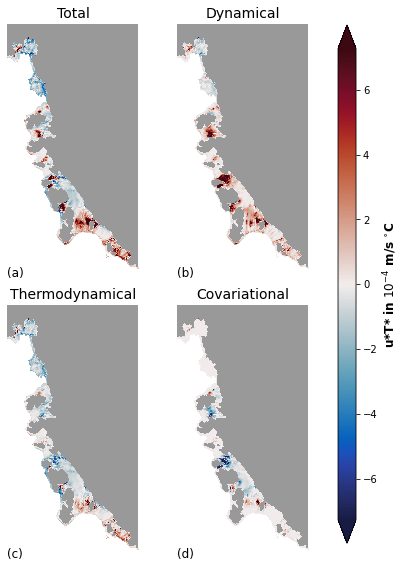

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideASeas.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


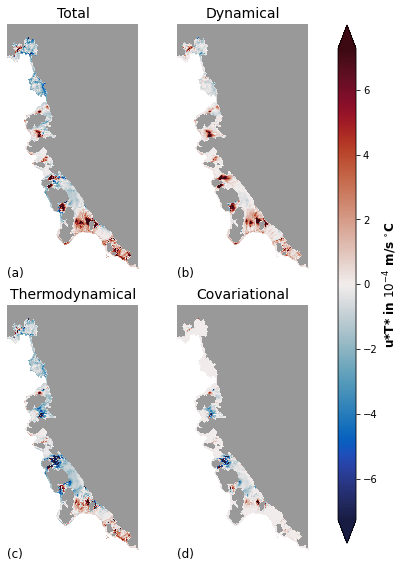

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralASeas.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


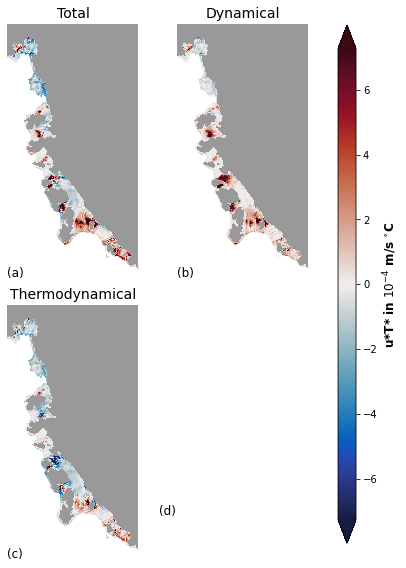

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideBSeas.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


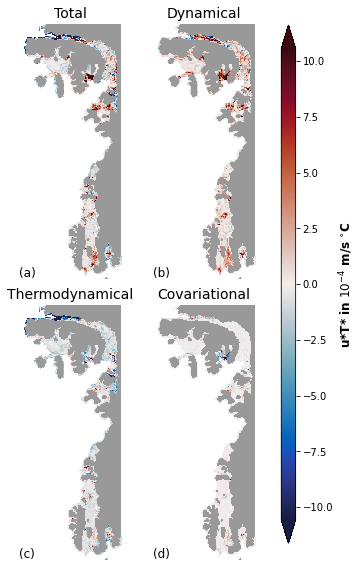

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideBSeas.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


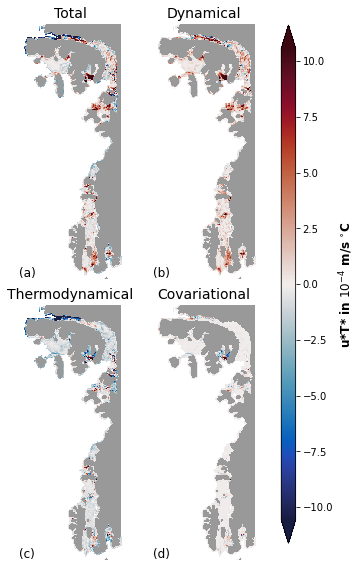

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralBSeas.nc


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


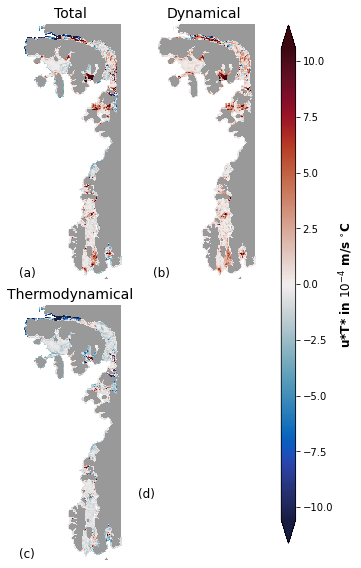

In [50]:
reg = 'ASeas'
save=True
plot_decomp(reg,'RefNoTide',figsize=(5,8),save=save)
plot_decomp(reg,'RefTide',figsize=(5,8),save=save)
plot_decomp(reg,'RefCentral',figsize=(5,8),save=save)

reg = 'BSeas'

save = True
plot_decomp(reg,'RefNoTide',figsize=(4,8),save=save)
plot_decomp(reg,'RefTide',figsize=(4,8),save=save)
plot_decomp(reg,'RefCentral',figsize=(4,8),save=save)

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


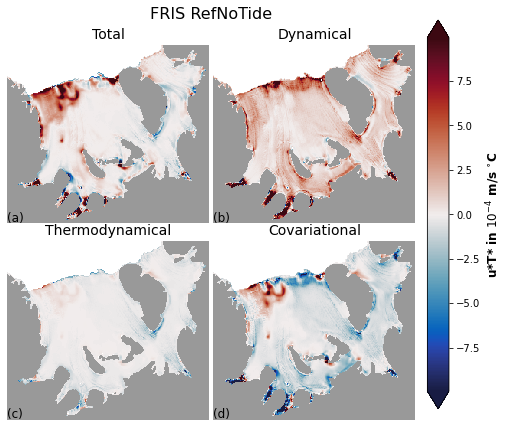

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


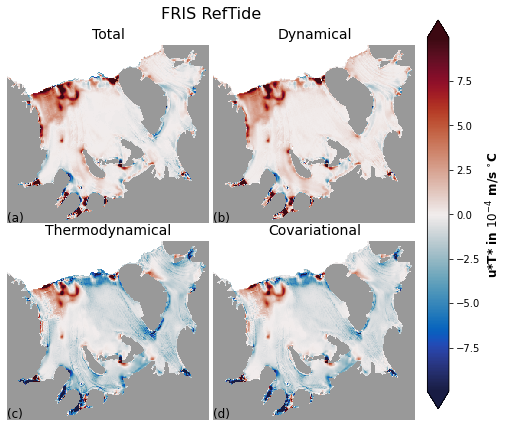

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


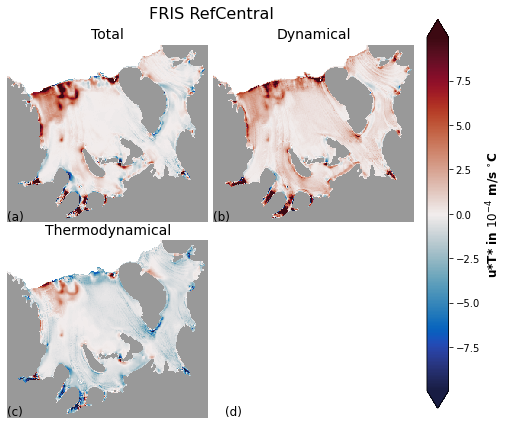

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideShackleton.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


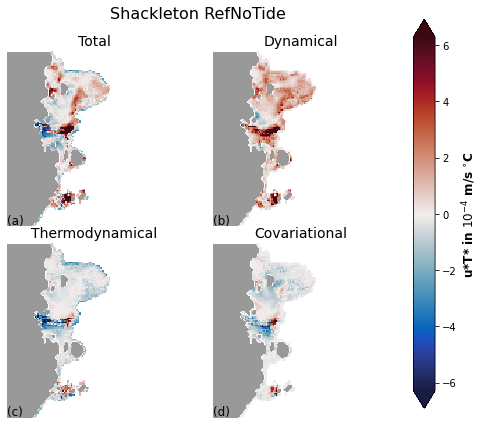

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideShackleton.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


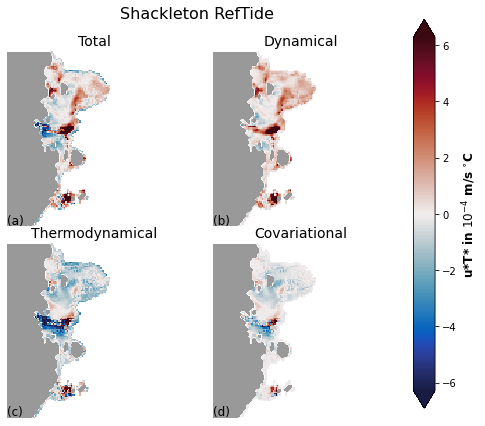

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralShackleton.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


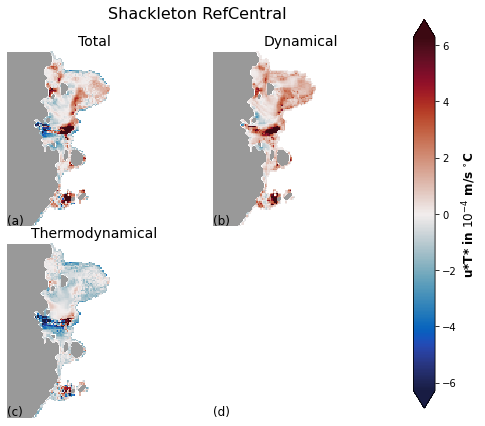

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideRoss.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


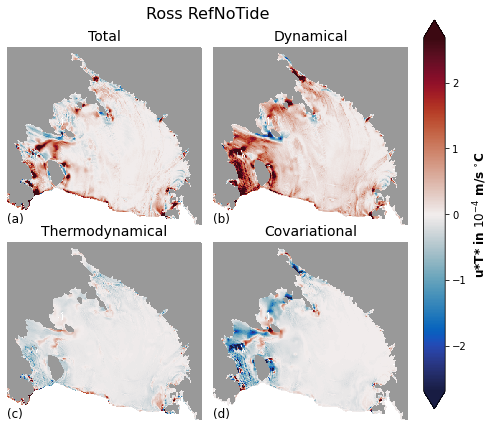

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideRoss.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


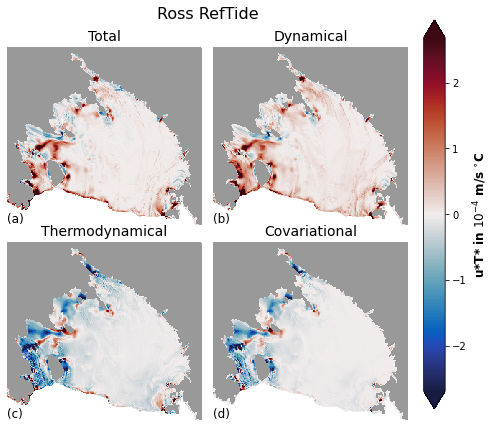

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralRoss.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


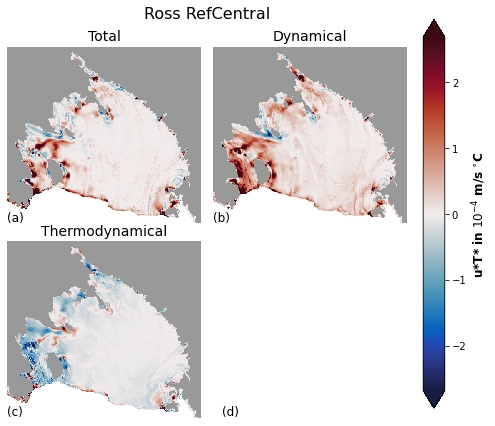

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideGeorgeV.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


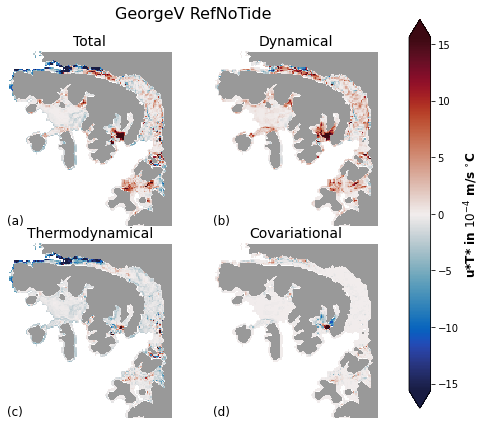

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideGeorgeV.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


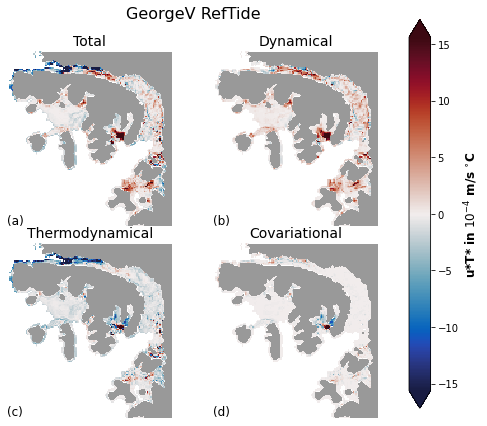

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralGeorgeV.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


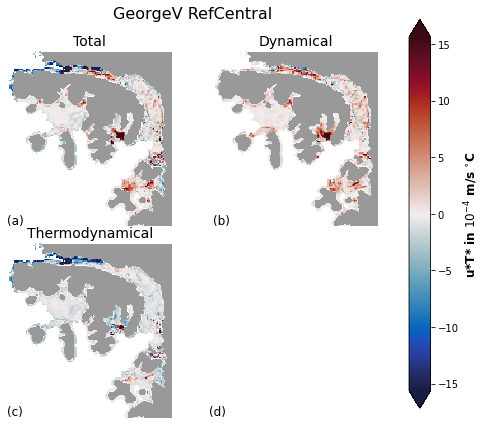

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTidePI.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


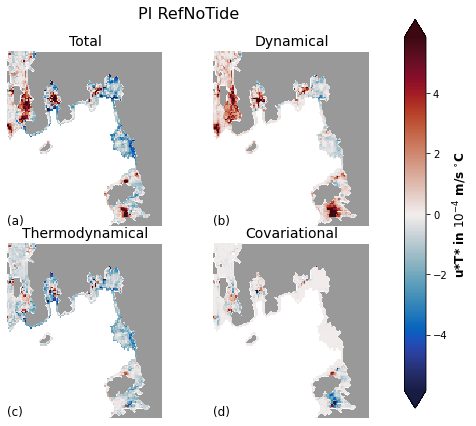

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTidePI.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


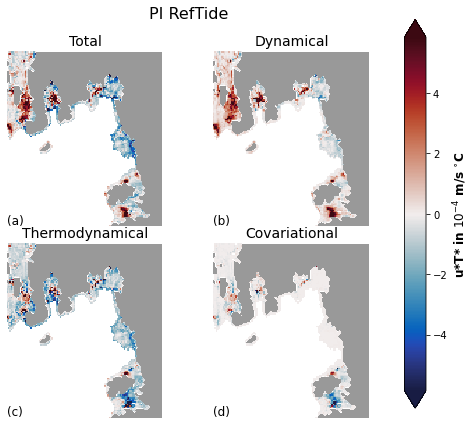

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralPI.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


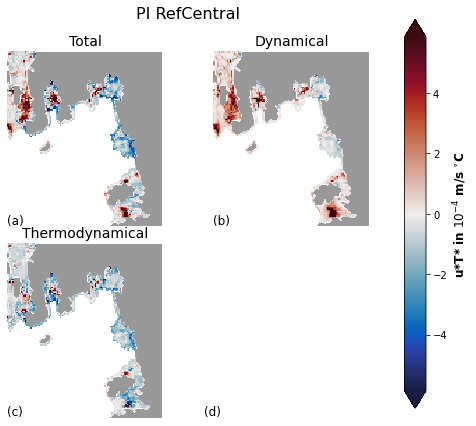

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideTotten.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


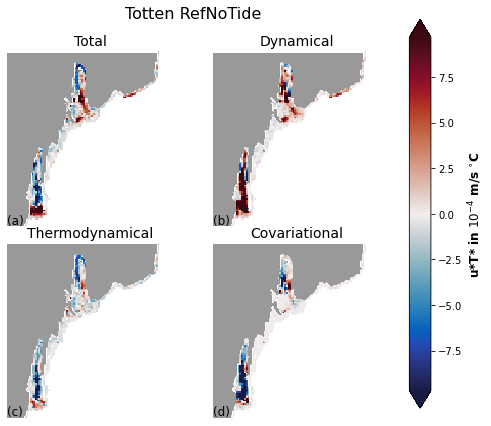

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideTotten.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


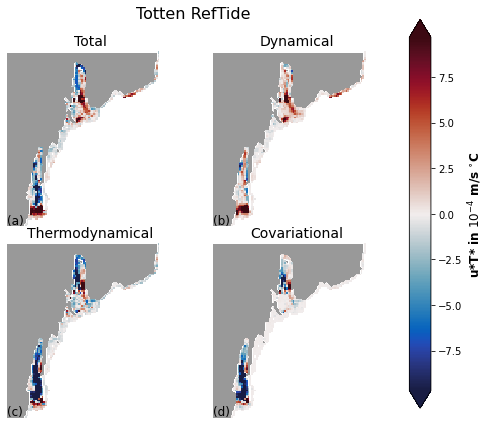

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralTotten.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


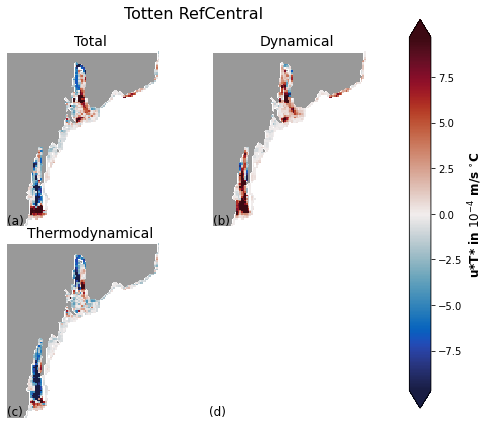

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideAmery.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


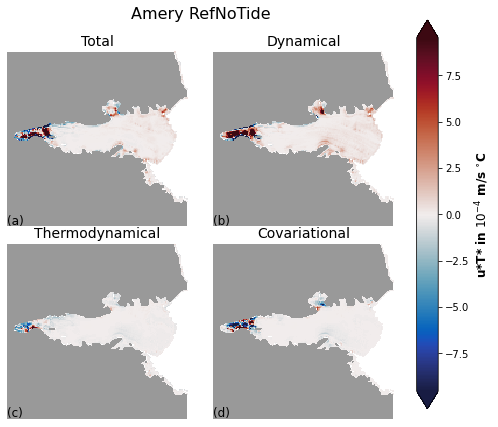

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideAmery.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


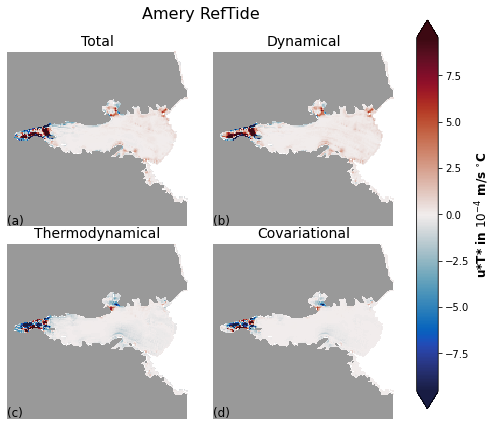

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralAmery.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


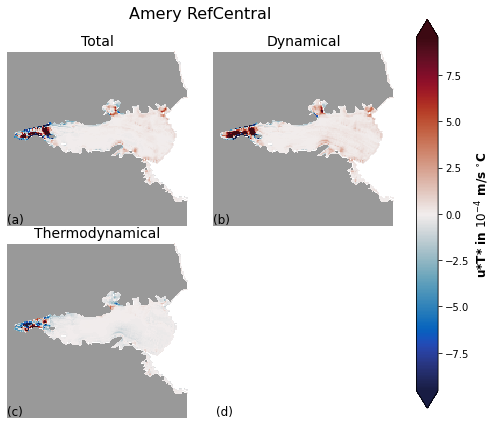

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideFimbul.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


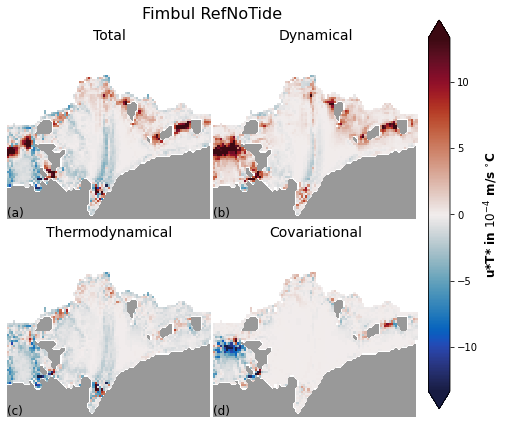

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideFimbul.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


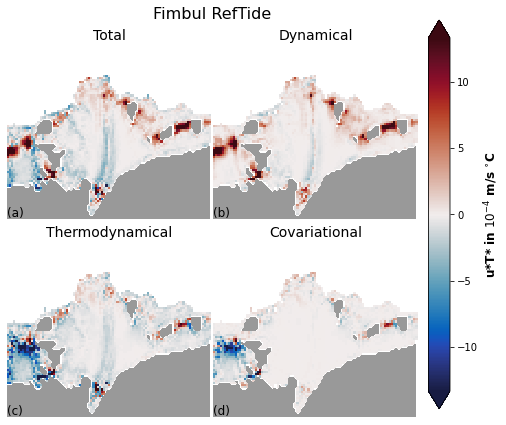

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralFimbul.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


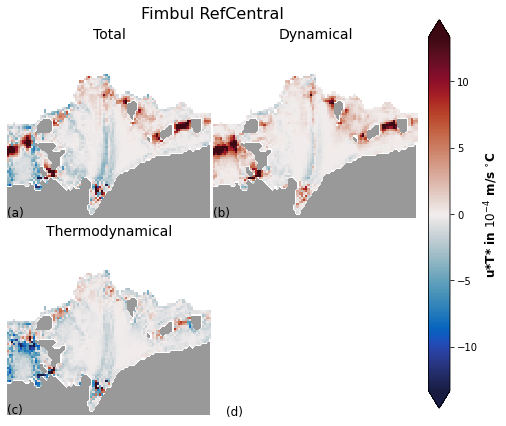

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideLarsenC.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


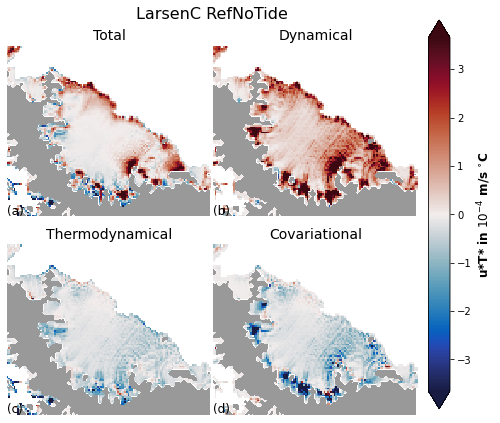

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideLarsenC.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


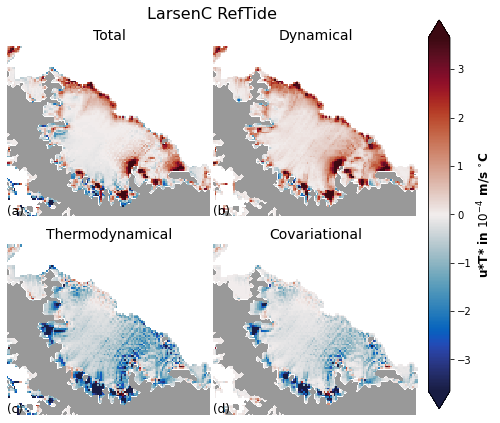

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralLarsenC.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


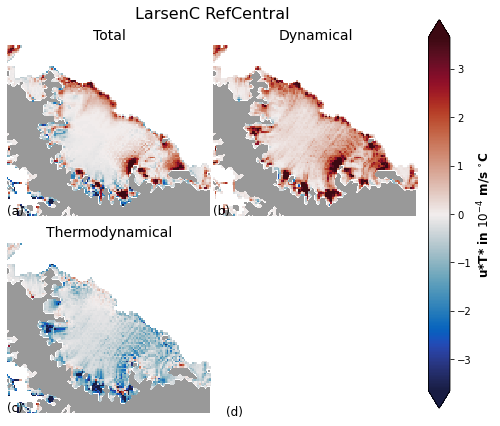

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideMertz.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


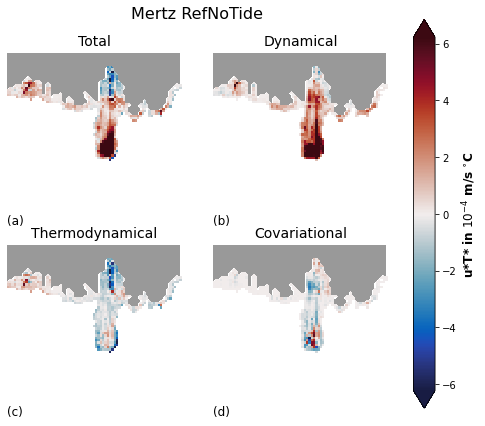

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideMertz.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


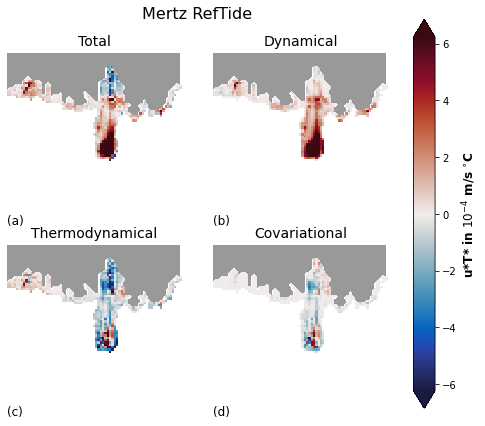

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralMertz.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


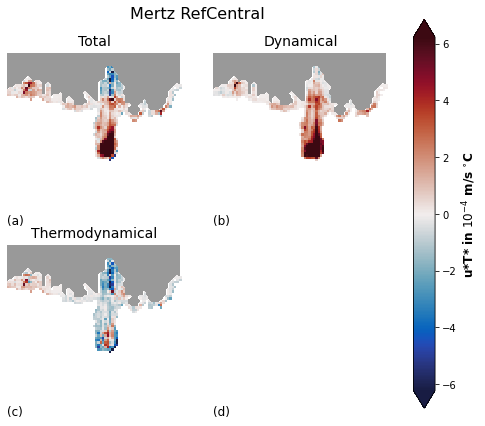

In [27]:
#regions = ['PI']

regions = ['FRIS','Shackleton','Ross','GeorgeV','PI','Totten','Amery','Fimbul',
        'LarsenC','Mertz']

save = True
for reg in regions:
    plot_decomp(reg,'RefNoTide',figsize=(6,6),save=save)
    plot_decomp(reg,'RefTide',figsize=(6,6),save=save)
    plot_decomp(reg,'RefCentral',figsize=(6,6),save=save)

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralJelbart.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


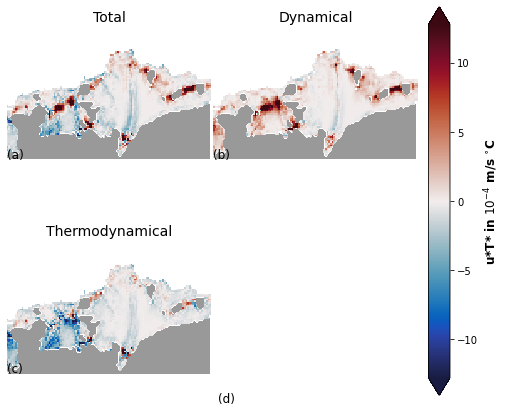

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralRiiser-Larsen.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


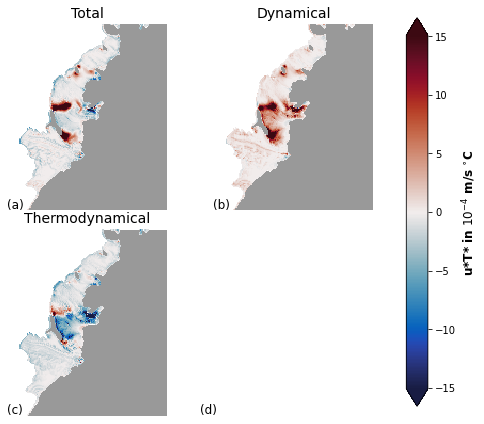

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralNickerson.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


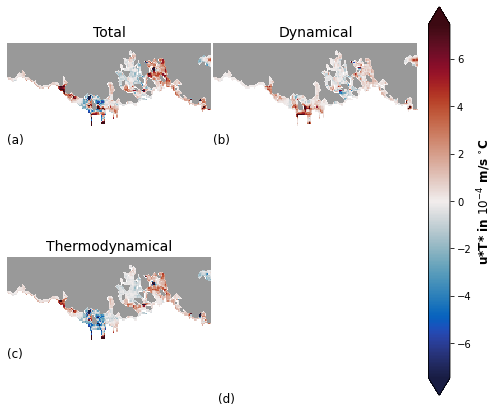

In [85]:
%matplotlib inline
regions = ['Jelbart','Riiser-Larsen','Nickerson']

save = False
for reg in regions:
    plot_decomp(reg,'RefCentral',figsize=(6,6),save=save)

FRIS
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


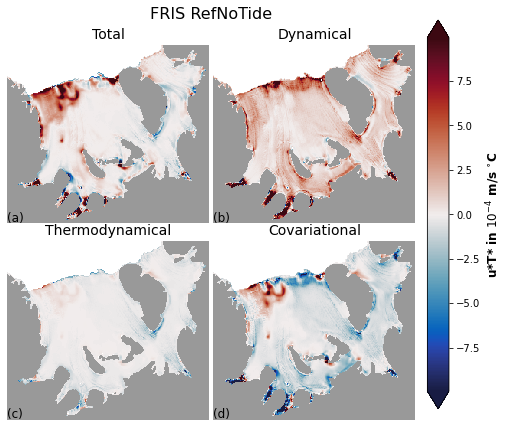

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


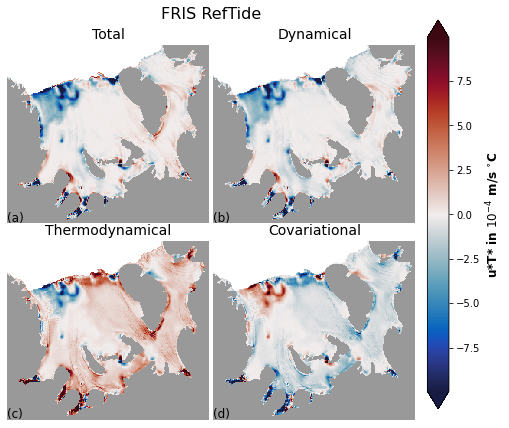

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


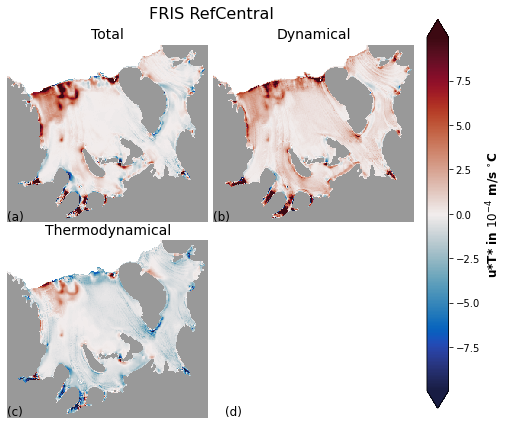

Shackleton
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideShackleton.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


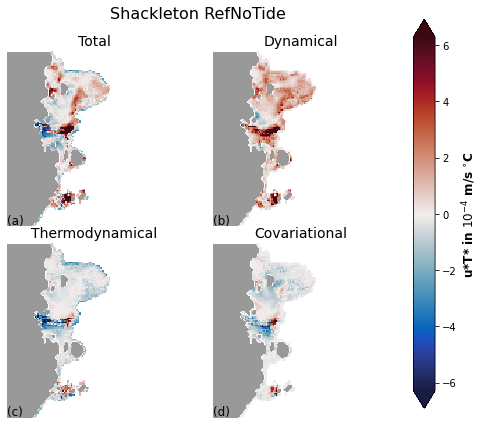

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideShackleton.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


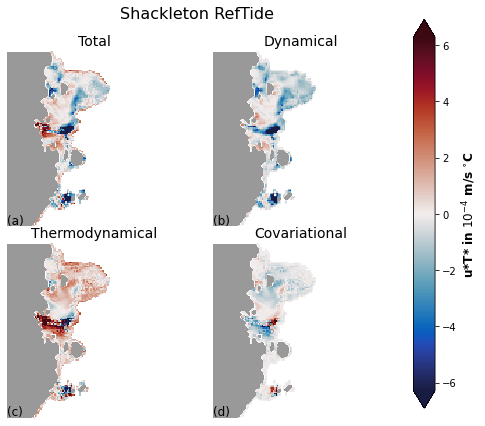

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralShackleton.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


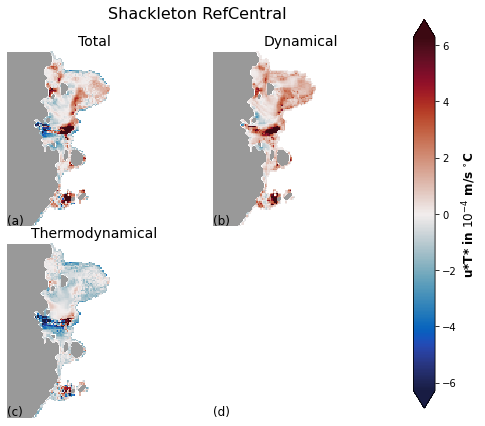

Ross
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideRoss.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


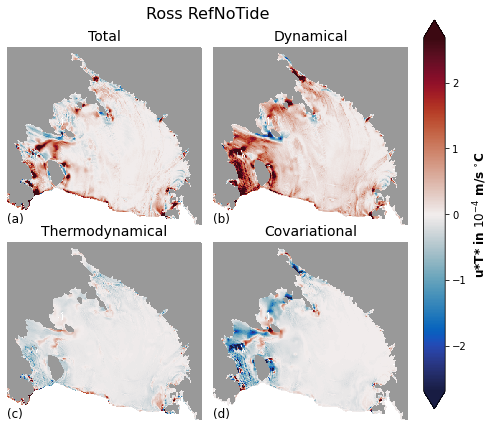

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideRoss.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


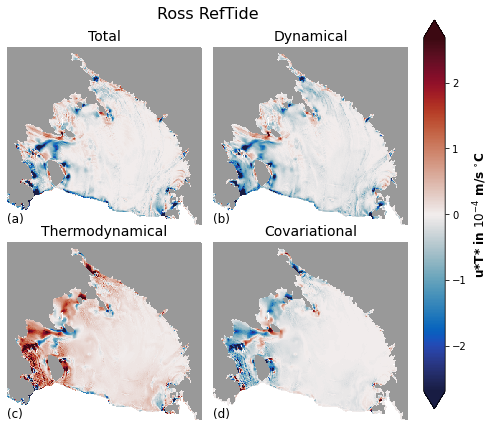

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralRoss.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


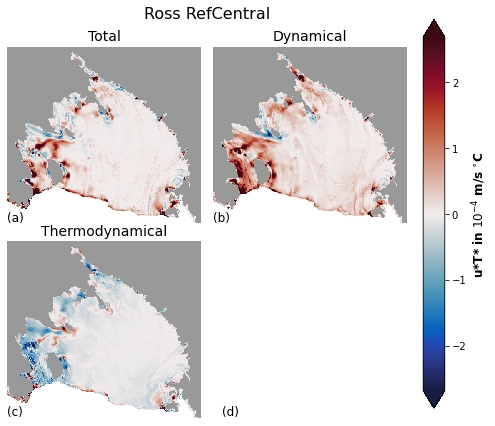

GeorgeV
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideGeorgeV.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


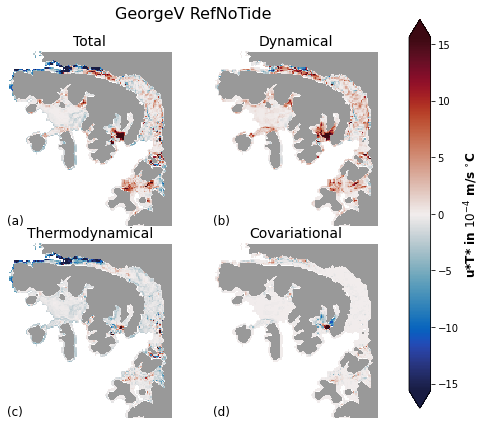

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideGeorgeV.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


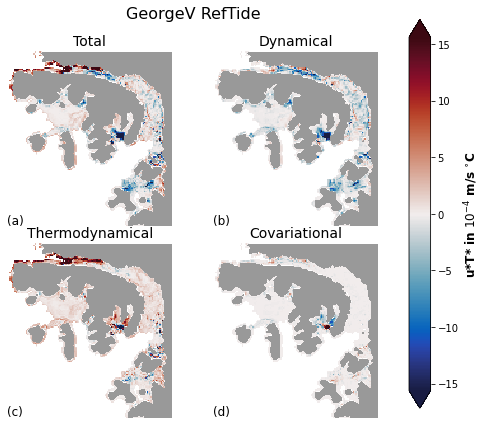

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralGeorgeV.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


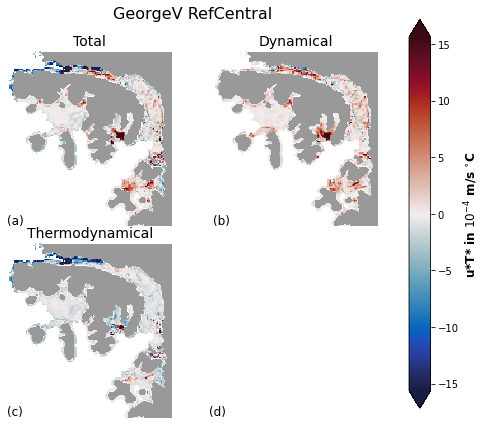

PI
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTidePI.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


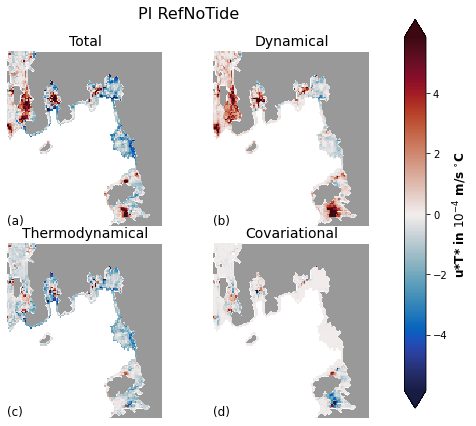

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTidePI.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


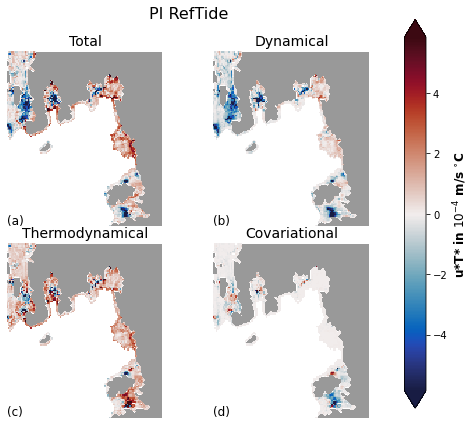

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralPI.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


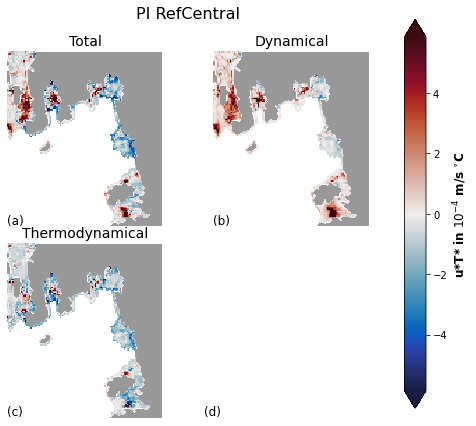

Totten
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideTotten.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


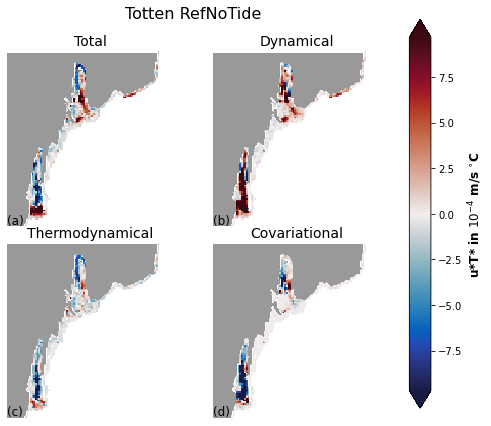

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideTotten.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


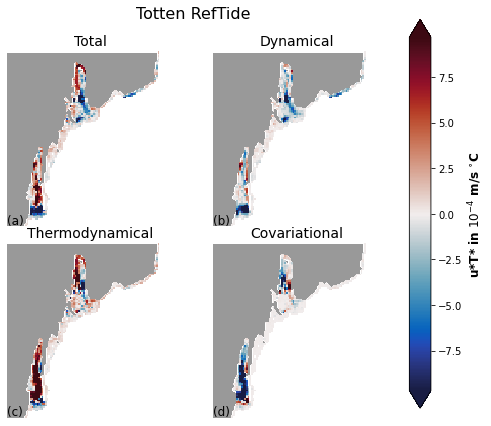

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralTotten.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


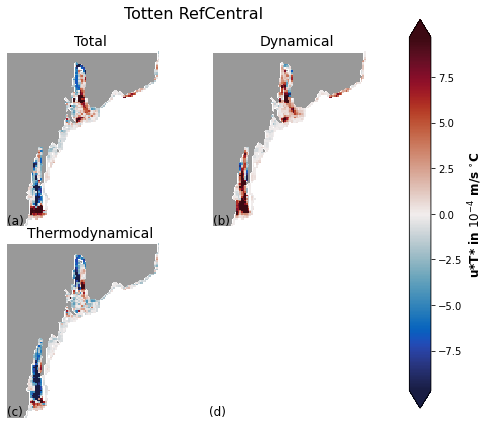

Amery
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideAmery.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


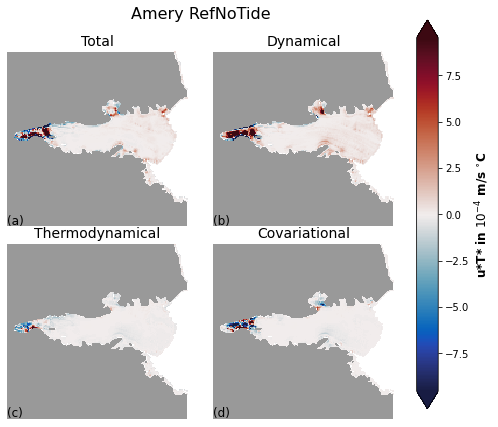

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideAmery.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


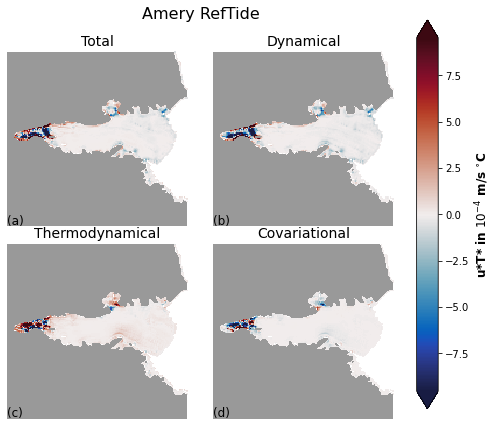

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralAmery.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


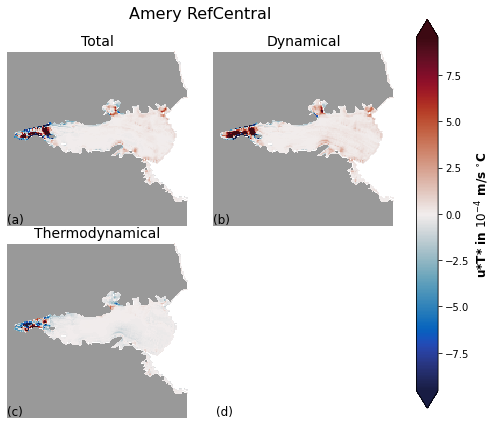

Fimbul
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideFimbul.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


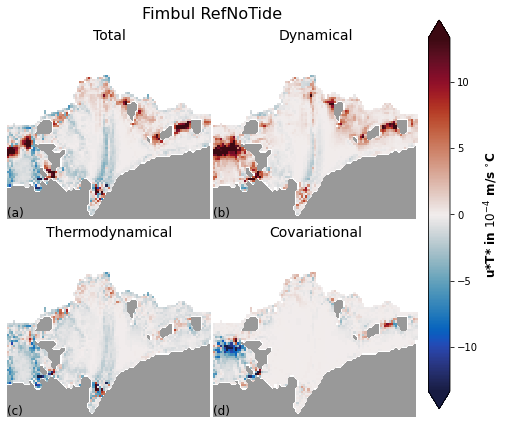

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideFimbul.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


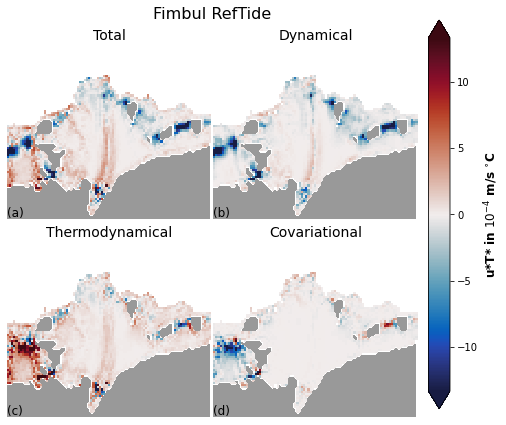

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralFimbul.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


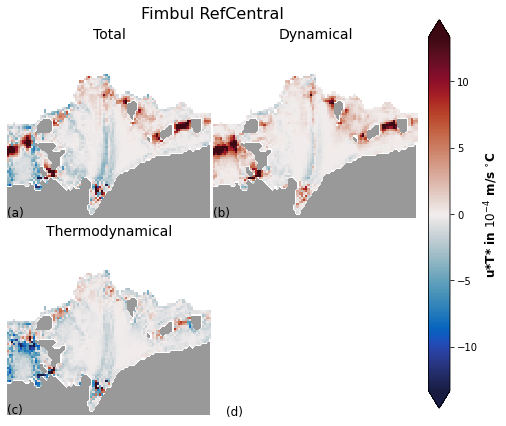

LarsenC
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideLarsenC.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


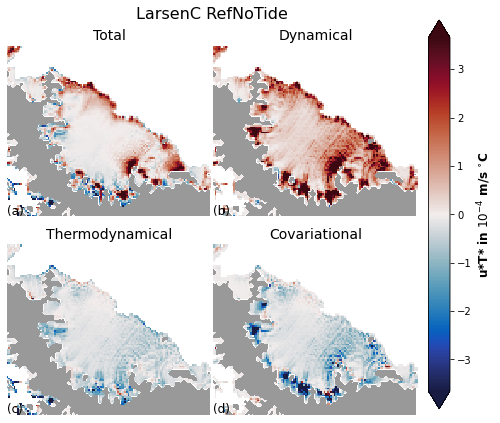

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideLarsenC.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


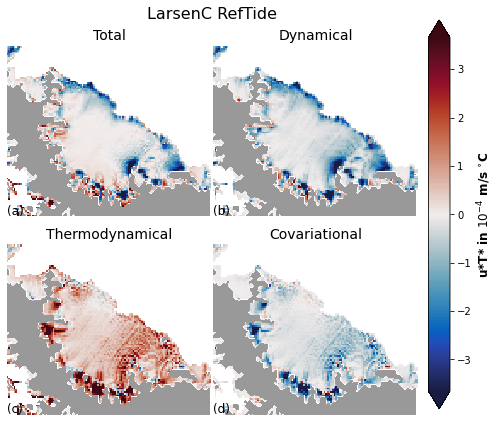

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralLarsenC.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


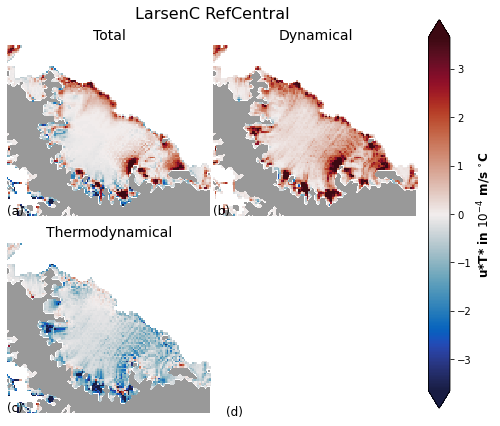

Mertz
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefNoTideMertz.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


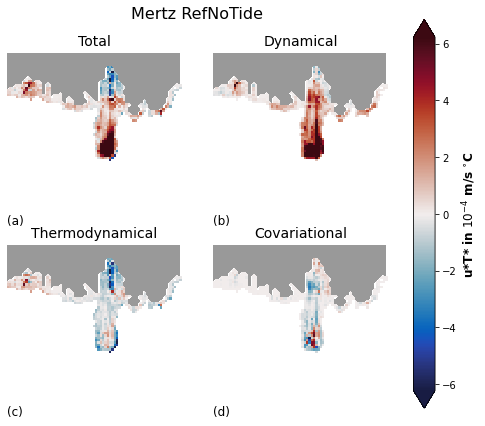

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideMertz.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


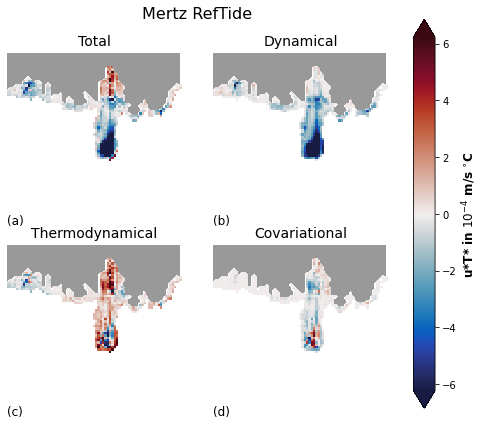

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralMertz.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


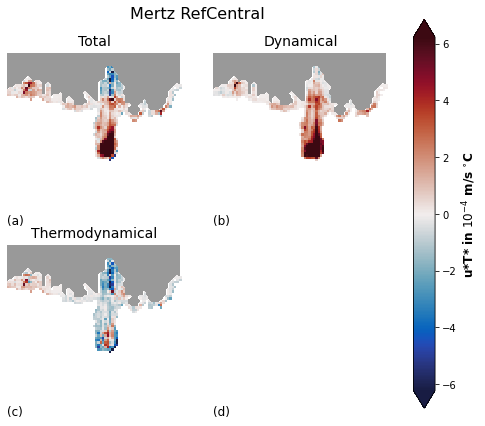

In [25]:
regions = ['FRIS','Shackleton','Ross','GeorgeV','PI','Totten','Amery','Fimbul',
        'LarsenC','Mertz']
save=False
for reg in regions:
    print(reg)
    #decomp = xr.open_dataset(os.path.join(base_path,'decomp'+reg+'.nc'))
    #decomp.attrs['region']=reg
    #vmax = decomp.dMstar.std()*40000
    #plot_decomp(decomp,grd.isel(sels[reg]),vmin=-vmax,vmax=vmax,figsize=(6,6))
    plot_decomp(reg,'RefNoTide',figsize=(6,6),save=save)
    plot_decomp(reg,'RefTide',figsize=(6,6),save=save)
    plot_decomp(reg,'RefCentral',figsize=(6,6),save=save)

# only central for manuscript
missing right cscale for second region, colorbars 

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_decomp(regs, figsize=(6,4),save=False,title=False,
                gridspec_kw={"width_ratios":[1, 1, 1, 0.05],"height_ratios":[0.98,1,0.9,0.7]}):
    base_path = os.path.join(raw_dir,'scratch','decomp','regions') 
    
    fig,axes = plt.subplots(ncols=4,nrows=np.size(regs,0),figsize=figsize,
                            gridspec_kw=gridspec_kw)
    
    for i,reg in enumerate(regs):
        file = os.path.join(base_path,'decompRefCentral'+reg+'.nc')
        print('processing file: '+file)
        decomp = xr.open_dataset(file)
        grds = grd.isel(sels[reg])
        vmax = decomp.dMstar.std()*40000
        vmax=7
        vmin=-vmax
    
        plot,axes[i,0] = plot_m(axes[i,0],decomp.dMstar,grds,'Total',vmin,vmax)
        plot,axes[i,1] = plot_m(axes[i,1],decomp.dyn,grds,'Dynamical',vmin,vmax)
        plot,axes[i,2] = plot_m(axes[i,2],decomp.therm,grds,'Thermodynamical',vmin,vmax)
        
        cb = fig.colorbar(plot, cax=axes[i,3],extend='both',shrink=0.5)
        cb.set_label(label='u*T* in $10^{-4}$ m/s $^{\circ}$C',size=12)

    for ax in axes[:,:-1].flatten():
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_facecolor('gray')
    for ax in axes[1:,:].flatten():
        ax.set_title("")
        
    n=0
    for n,ax in enumerate(axes[:,:-1].flatten()):
        ax.text(0.01, 0.02, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

    if title:
        fig.suptitle(title,size=16)
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.01,hspace=0.05)
    if save:
        plt.savefig(os.path.join(fig_dir,'dynThermDecomp'+save+'.png'),format='png',dpi=300,bbox_inches = "tight")
    plt.show()

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralFRIS.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralRoss.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralLarsenC.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralJelbart.nc


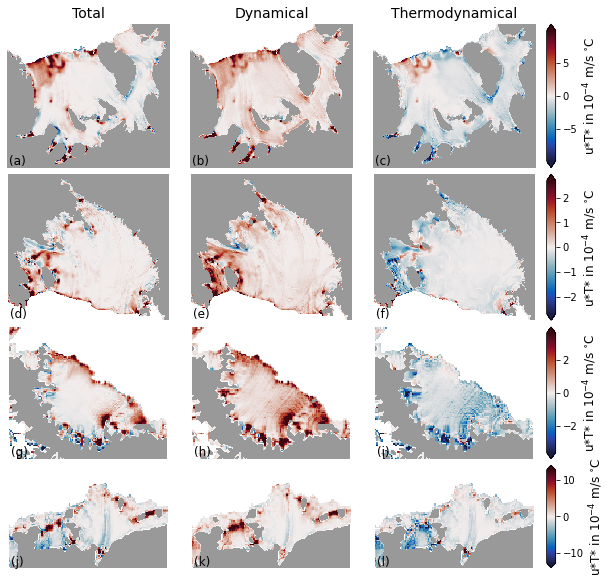

In [155]:
plot_decomp(['FRIS','Ross','LarsenC','Jelbart'],figsize=(10,10),save='FrisRossLarsenFimbul')

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralASeas.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralBSeas.nc


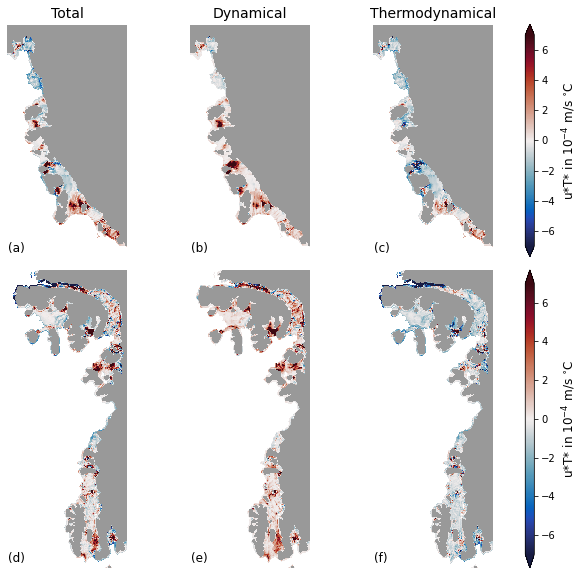

In [24]:
plot_decomp(['ASeas','BSeas'],figsize=(10,10),save='ASeasBSeas',
            gridspec_kw={"width_ratios":[1, 1,1,0.05],"height_ratios":[0.78,1]})

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralAmery.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralMertz.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralShackleton.nc


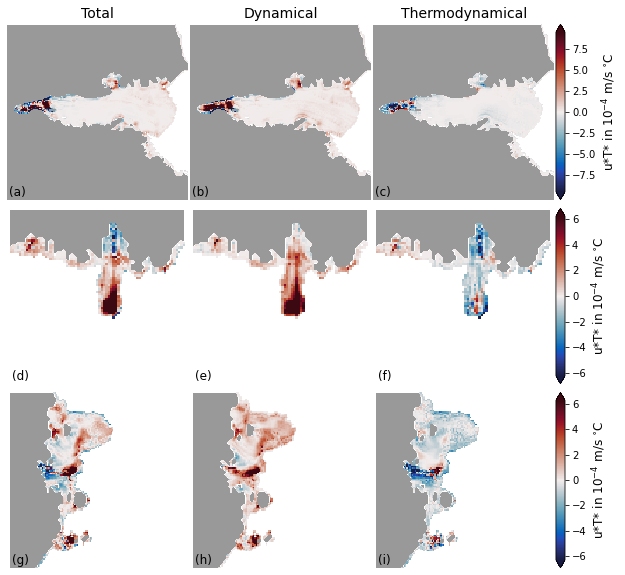

In [157]:
plot_decomp(['Amery','Mertz','Shackleton'],figsize=(10,10),save='AmeryMertzShackleton',
            gridspec_kw={"width_ratios":[1, 1,1,0.05],"height_ratios":[1,1,1]})

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralTotten.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralRiiser-Larsen.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralNickerson.nc


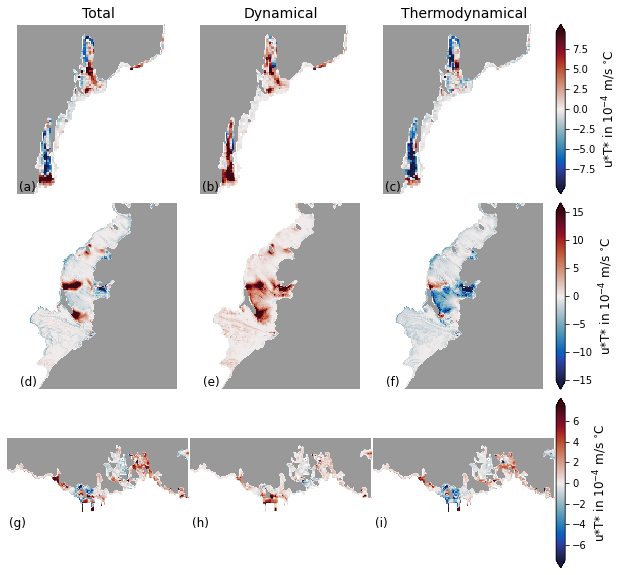

In [158]:
plot_decomp(['Totten','Riiser-Larsen','Nickerson'],figsize=(10,10),save='TottenRiiserNickerson',
            gridspec_kw={"width_ratios":[1, 1,1,0.05],"height_ratios":[1,1.1,1]})

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralASeas.nc
processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefCentralBSeas.nc


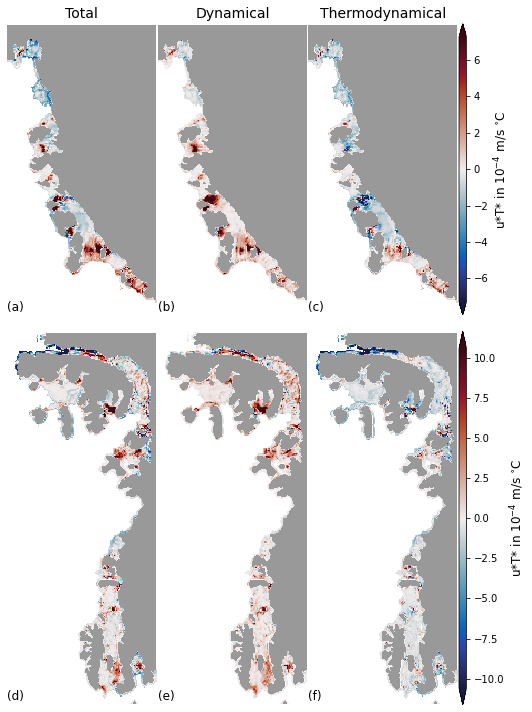

In [132]:
def plot_decomp(reg1, reg2, figsize=(6,4),save=False,title=False):
    base_path = os.path.join(raw_dir,'scratch','decomp','regions') 
    
    fig,axes = plt.subplots(ncols=4,nrows=2,figsize=figsize,
                            gridspec_kw={"width_ratios":[1, 1,1,0.05],"height_ratios":[0.78,1]})
    #ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
    
    for i,reg in enumerate([reg1,reg2]):
        file = os.path.join(base_path,'decompRefCentral'+reg+'.nc')
        print('processing file: '+file)
        decomp = xr.open_dataset(file)
        grds = grd.isel(sels[reg])
        vmax = decomp.dMstar.std()*40000
        vmin=-vmax
    
        plot,axes[i,0] = plot_m(axes[i,0],decomp.dMstar,grds,'Total',vmin,vmax)
        plot,axes[i,1] = plot_m(axes[i,1],decomp.dyn,grds,'Dynamical',vmin,vmax)
        plot,axes[i,2] = plot_m(axes[i,2],decomp.therm,grds,'Thermodynamical',vmin,vmax)
        
        cb = fig.colorbar(plot, cax=axes[i,3],extend='both',shrink=0.6)
        cb.set_label(label='u*T* in $10^{-4}$ m/s $^{\circ}$C',size=12)

    for ax in axes[:,:-1].flatten():
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_facecolor('gray')
    for ax in axes[1:,:].flatten():
        ax.set_title("")
        
    n=0
    for n,ax in enumerate(axes[:,:-1].flatten()):
        ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

    if title:
        fig.suptitle(title,size=16)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01,hspace=0.05)
    if save:
        plt.savefig(os.path.join(fig_dir,'dynThermDecomp'+ref+reg+'.png'),format='png',bbox_inches = "tight")
    plt.show()
    


# old stuff

In [65]:
def plot_decomp(reg,ref,vmin=None,vmax=None,figsize=(6,4),save=False,title=False):
    base_path = os.path.join(raw_dir,'scratch','decomp','regions') 
    file = os.path.join(base_path,'decomp'+ref+reg+'.nc')
    print('processing file: '+file)
    decomp = xr.open_dataset(file)
    #decomp.attrs['region']=reg
    grds = grd.isel(sels[reg])
    if vmax==None:
        vmax = decomp.dMstar.std()*40000
        vmin=-vmax
    
    fig,axes = plt.subplots(ncols=2,nrows=2,figsize=figsize)
    ax1,ax2,ax3,ax4 = axes.flatten()
    
    plot,ax1 = plot_m(ax1,-decomp.dMstar,grds,'Total',vmin,vmax)
    plot,ax2 = plot_m(ax2,-decomp.dyn,grds,'Dynamical',vmin,vmax)
    plot,ax3 = plot_m(ax3,-decomp.therm,grds,'Thermodynamical',vmin,vmax)
    plot,ax4 = plot_m(ax4,-(decomp.therm+decomp.cov),grds,'Therm.+Covar.',vmin,vmax)
    
    n=0
    for n,ax in enumerate(axes.flatten()):
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_facecolor('gray')
        ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)
    
    cax = fig.add_axes([1.0, 0.05, 0.05, 0.9])
    cbar = fig.colorbar(plot,cax=cax,extend='both')
    cbar.set_label(label='u*T* in $10^{-4}$ m/s $^{\circ}$C',weight='bold',size=12)
    #cbar = fig.colorbar(plot, ax=axes.ravel().tolist(), shrink=0.95)
    #fig.suptitle(reg+' '+ref,size=16) 
    if title:
        fig.suptitle(title,size=16)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01,hspace=0.1)
    if save:
        plt.savefig(os.path.join(fig_dir,'dynThermDecomp'+ref+reg+'.png'),format='png',bbox_inches = "tight")
    plt.show()

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideASeas.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


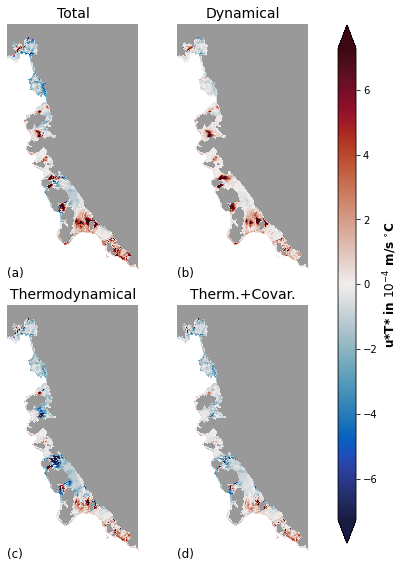

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideBSeas.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


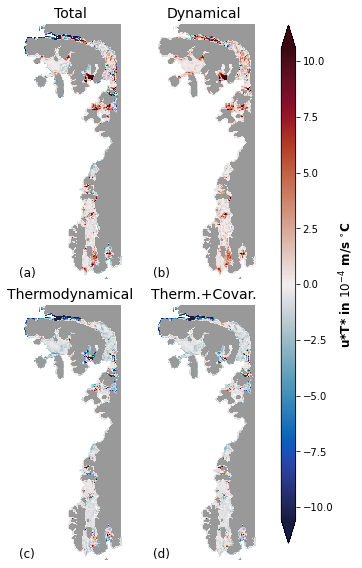

In [66]:
reg = 'ASeas'
save=False
plot_decomp(reg,'RefTide',figsize=(5,8),save=save)
reg = 'BSeas'
plot_decomp(reg,'RefTide',figsize=(4,8),save=save)

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideFRIS.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


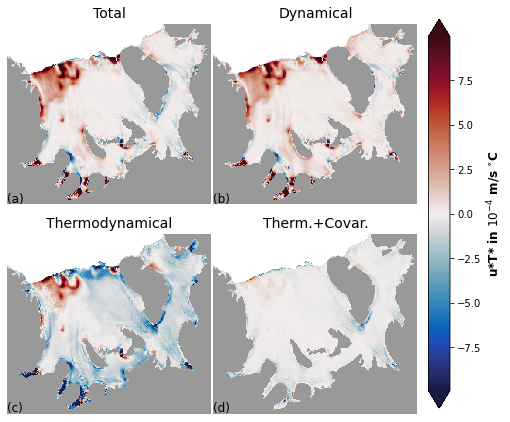

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideShackleton.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


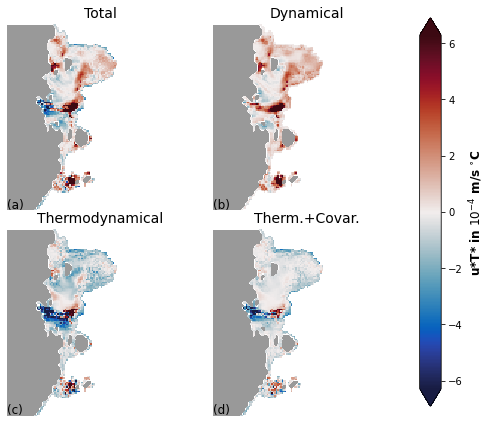

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideRoss.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


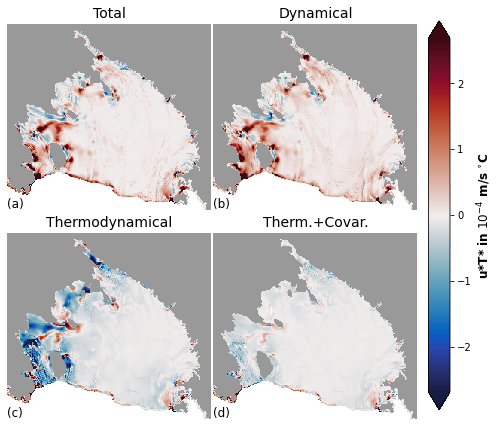

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideGeorgeV.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


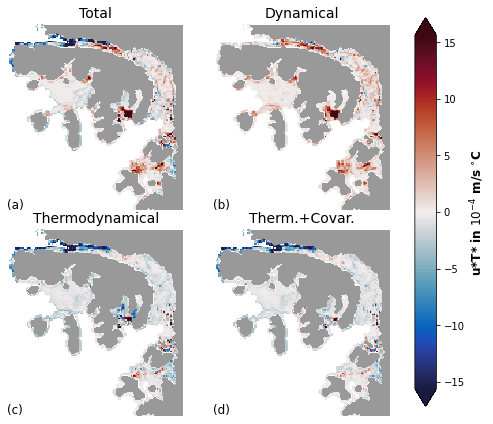

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTidePI.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


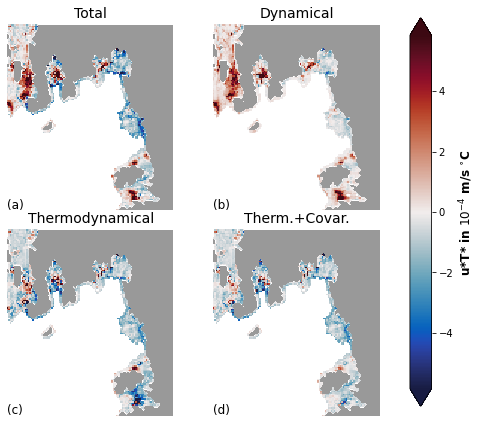

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideTotten.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideAmery.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


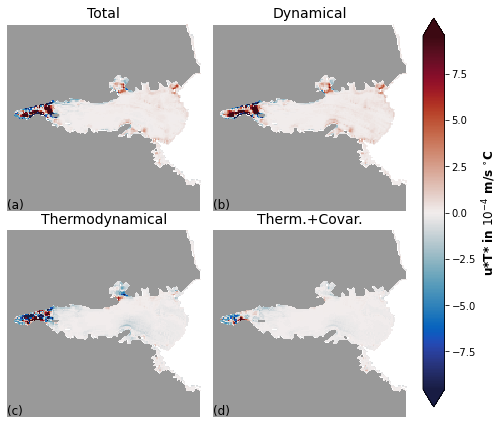

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideFimbul.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


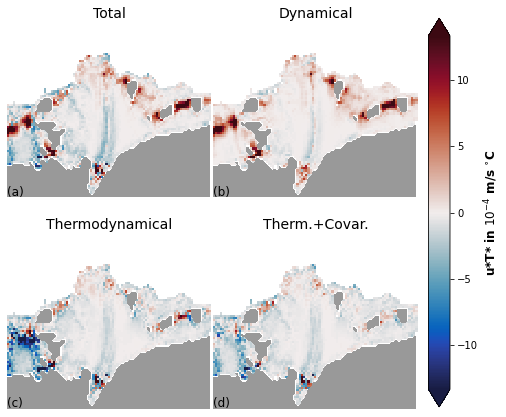

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideLarsenC.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


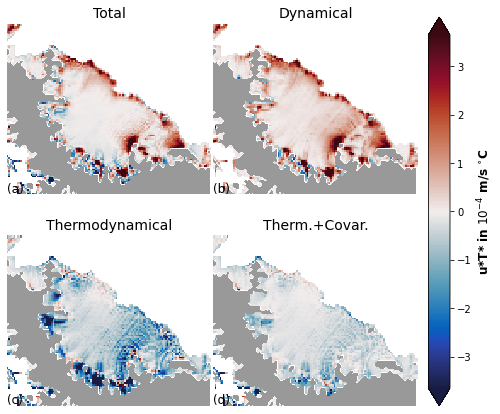

processing file: /home/ubuntu/bigStick/antarctic_melting/data/analysis/raw/scratch/decomp/regions/decompRefTideMertz.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


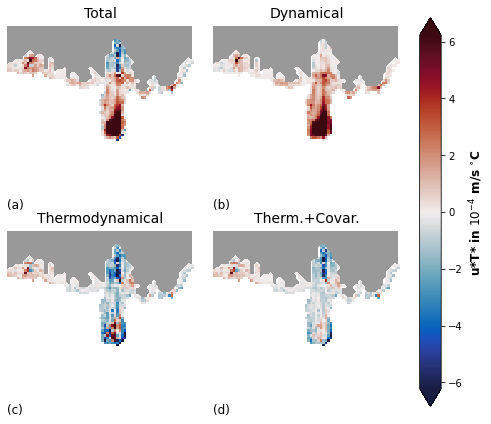

In [67]:
regions = ['FRIS','Shackleton','Ross','GeorgeV','PI','Totten','Amery','Fimbul',
        'LarsenC','Mertz']
save=False
for reg in regions:
    plot_decomp(reg,'RefTide',figsize=(6,6),save=save)

FRIS


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


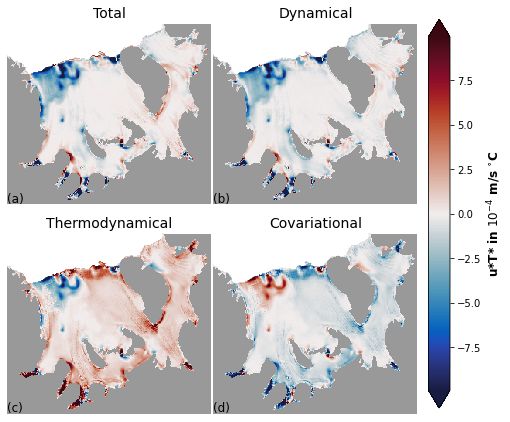

Shackleton


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


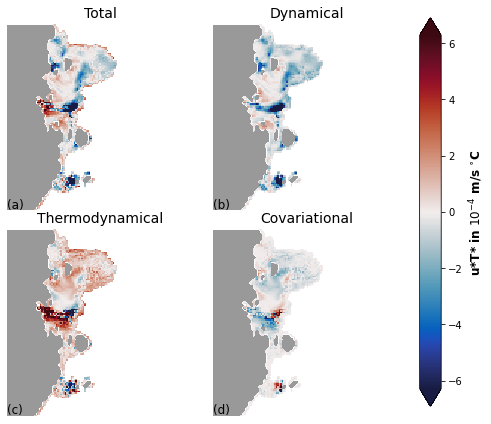

Ross


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


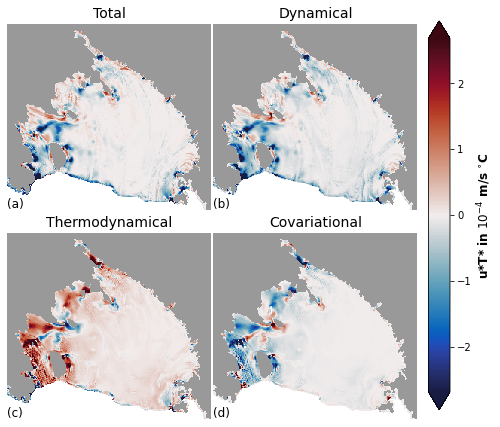

GeorgeV


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


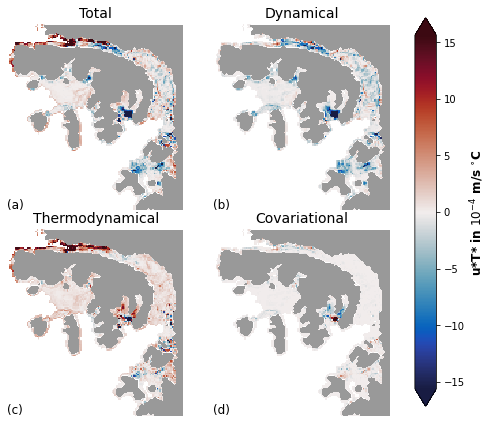

PI


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


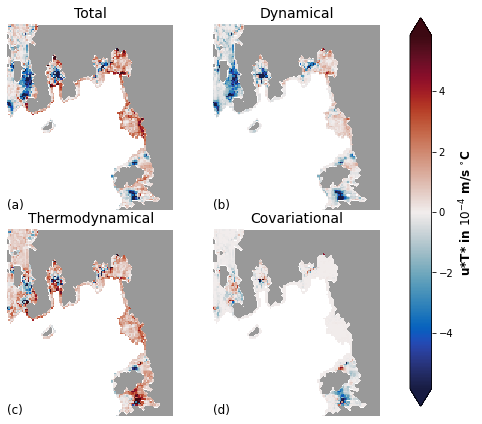

Totten


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


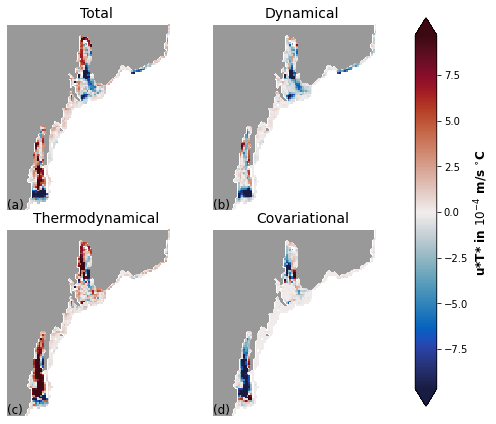

Amery


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


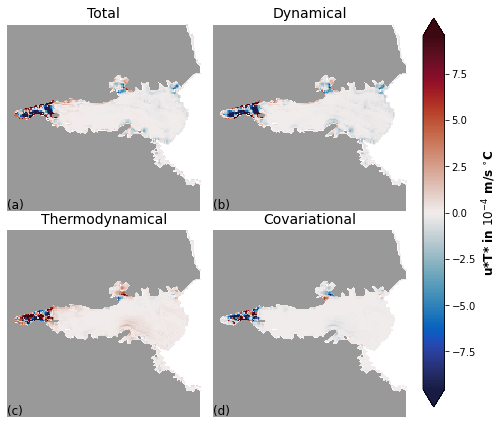

Fimbul


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


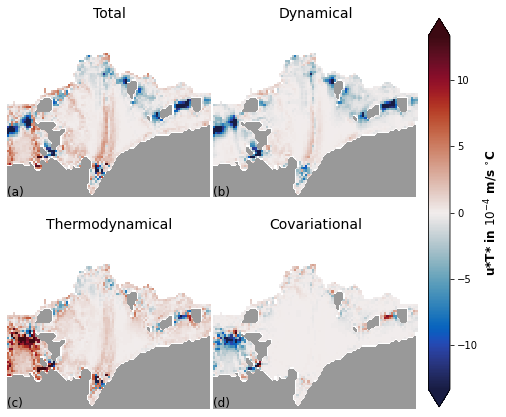

LarsenC


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


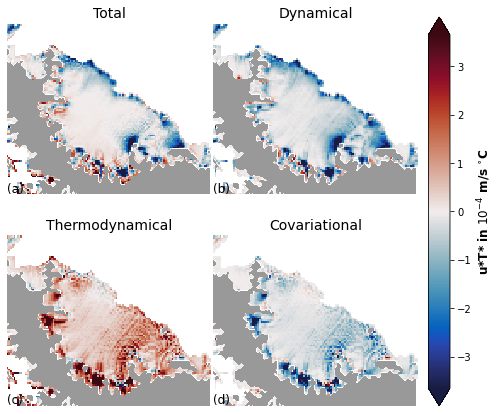

Mertz


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


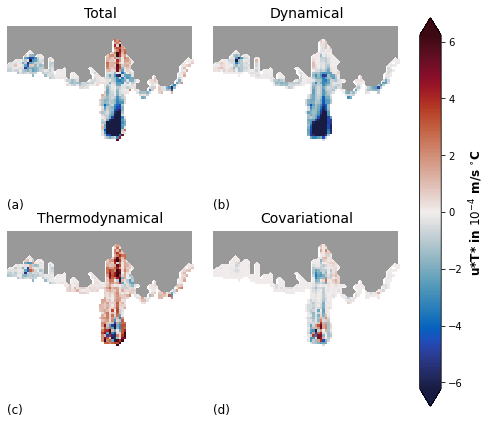

In [40]:
regions = ['FRIS','Shackleton','Ross','GeorgeV','PI','Totten','Amery','Fimbul',
        'LarsenC','Mertz']
for reg in regions:
    print(reg)
    decomp = xr.open_dataset(os.path.join(base_path,'decomp_reverse_'+reg+'.nc'))
    decomp.attrs['region']=reg
    vmax = decomp.dMstar.std()*40000
    plot_decomp(decomp,grd.isel(sels[reg]),vmin=-vmax,vmax=vmax,figsize=(6,6))

In [9]:
file_path = os.path.join(raw_dir,'scratch','waom4','ocean_avg_hr_0010.nc')
tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
file_path = os.path.join(raw_dir,'scratch','waom4_nt','ocean_avg_hr_0010.nc')
no_tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True
mask_shelf['Total Antarctica'][:,1500:] = False

grd.mask_rho[570:610,1030:1140] = False

In [3]:
sel1 = {'xi_rho':slice(714,1243),'eta_rho':slice(1408,1875)} #FRIS
sel2 = {'xi_rho':slice(1185,1726),'eta_rho':slice(652,1146)} #Ross
sel3 = {'xi_rho':slice(380,648),'eta_rho':slice(1114,1780)} #BSeas
sel4 = {'xi_rho':slice(655,924),'eta_rho':slice(720,1244)} #ASeas
sel5 = {'xi_rho':slice(2568,2665),'eta_rho':slice(637,867)} # Totten
sel6 = {'xi_rho':slice(2322,2652),'eta_rho':slice(1650,1781)} # Amery
sel7 = {'xi_rho':slice(1409,1595),'eta_rho':slice(2338,2496)} # Fimbul
sel8 = {'xi_rho':slice(295,534),'eta_rho':slice(1830,2030)} # LarsenC
sel9 = {'xi_rho':slice(390,650),'eta_rho':slice(1500,1775)} # GeorgeV
sel10 = {'xi_rho':slice(550,775),'eta_rho':slice(1000,1250)} # PI
sel11 = {'xi_rho':slice(2550,2750),'eta_rho':slice(650,860)} # Totten
sel12 = {'xi_rho':slice(2330,2640),'eta_rho':slice(1550,1850)} # Amery
sel13 = {'xi_rho':slice(425*5,455*5),'eta_rho':slice(45*5,75*5)} # Mertz
sel14 = {'xi_rho':slice(545*5,595*5),'eta_rho':slice(200*5,250*5)} # Shackleton

sels = {'Shackleton':sel14,'Ross':sel2,'GeorgeV':sel9,'PI':sel10,'Totten':sel11,'Amery':sel12,'Fimbul':sel7,
        'LarsenC':sel8,'Mertz':sel13,'BSeas':sel3}

In [ ]:
from dask.distributed import Client
C = Client()

for k,sel in sels.items():
    print(f'processing {k}')
    plot_region(tides,no_tides,sel,k)

processing Shackleton
subsetting ...
processing dyn component ...


In [ ]:
sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,950),
           'xi_u' : slice(350,649),'eta_u' : slice(700,950),
           'xi_v' : slice(350,650),'eta_v' : slice(700,949)}
FRIS = tides.isel(sel)
FRIS_nt = no_tides.isel(sel)
rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,950)}
FRIS_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

FRIS = FRIS.chunk(chunks)
FRIS_nt = FRIS_nt.chunk(chunks)

dyn2 = ((FRIS.ustar-FRIS_nt.ustar)*FRIS_nt.Tstar).where(FRIS_mask).mean('ocean_time').load()
print('ping')
therm2 = ((FRIS.Tstar-FRIS_nt.Tstar)*FRIS_nt.ustar).where(FRIS_mask).mean('ocean_time').load()
print('ping')
cov2 = ((FRIS.ustar-FRIS_nt.ustar)*(FRIS.Tstar-FRIS_nt.Tstar)).where(FRIS_mask).mean('ocean_time').load()
print('ping')
dMstar2 = ((FRIS.ustar*FRIS.Tstar).where(FRIS_mask).mean('ocean_time')-
          (FRIS_nt.ustar*FRIS_nt.Tstar).where(FRIS_mask).mean('ocean_time')).load()
print('ping')
dsum2 = (therm2+cov2+dyn2).load()

In [ ]:
fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(12,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dMstar2,'dMstar')
ax2 = plot_m(ax2,dsum2,'therm+dyn+cov')
ax3 = plot_m(ax3,therm2,'therm')
ax4 = plot_m(ax4,dyn2,'dyn')
ax5 = plot_m(ax5,cov2,'cov')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [16]:
sel = {'xi_rho' : slice(250,425),'eta_rho' : slice(350,700),
           'xi_u' : slice(250,424),'eta_u' : slice(350,700),
           'xi_v' : slice(250,425),'eta_v' : slice(350,699)}
AB = tides.isel(sel)
AB_nt = no_tides.isel(sel)
rho_sel = {'xi_rho' : slice(250,425),'eta_rho' : slice(350,700)}
AB_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

AB = AB.chunk(chunks)
AB_nt = AB_nt.chunk(chunks)

dyn = ((AB.ustar-AB_nt.ustar)*AB_nt.Tstar).where(AB_mask).mean('ocean_time').load()
print('ping')
therm = ((AB.Tstar-AB_nt.Tstar)*AB_nt.ustar).where(AB_mask).mean('ocean_time').load()
print('ping')
cov = ((AB.ustar-AB_nt.ustar)*(AB.Tstar-AB_nt.Tstar)).where(AB_mask).mean('ocean_time').load()
print('ping')
dMstar = ((AB.ustar*AB.Tstar).where(AB_mask).mean('ocean_time')-
          (AB_nt.ustar*AB_nt.Tstar).where(AB_mask).mean('ocean_time')).load()
print('ping')
dsum = (therm+cov+dyn).load()

KeyboardInterrupt: 

In [ ]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dMstar,'dMstar')
ax2 = plot_m(ax2,dsum,'therm+dyn+cov')
ax3 = plot_m(ax3,therm,'therm')
ax4 = plot_m(ax4,dyn,'dyn')
ax5 = plot_m(ax5,cov,'cov')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()